##  Import Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(0)
from nltk import word_tokenize
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.python.framework import ops

## Data Preparation

### Load Training DataFrame

In [2]:
posts_df = pickle.load(open('../data/training_posts.pkl', 'rb'))
posts_df.head()

,age,comment,likes/views,link,promo,user
0,2 DAYS AGO,found my new favorite park!,"405,059 likes",/BytNlrQhRx8/,0,chrissyteigen
1,3 DAYS AGO,Happy bebe!,"1,739,218",/Byqz8uZh73s/,0,chrissyteigen
2,5 DAYS AGO,coated in a paste of fresh garlic and filled w...,"2,931,603",/BymErW1B9eL/,0,chrissyteigen
3,5 DAYS AGO,this kid,"371,095 likes",/Byl-aHjBXFX/,0,chrissyteigen
4,JUNE 8,home tomorrow 😩,"859,039 likes",/ByduG0BB_A3/,0,chrissyteigen


In [3]:
posts_df.shape

(1065, 6)

In [4]:
posts_df['promo'].value_counts()

0    609
1    456
Name: promo, dtype: int64

57% of the training data is labeled as non-promotional captions and 43% of the training data is labeled as promotional material. Due to the fact that this is fairly balanced data, accuracy will be an appropriate metric for evaluation.

### Promotional Material By User
We want to see the proportion of promotional material by user.

In [5]:
average_promos_by_user = posts_df.groupby('user')['promo'].mean()
average_promos_by_user.head()

user
_dealcasino_     0.68
abbycorkins      0.64
airbnb           1.00
alabamahannah    0.68
aliwong          0.80
Name: promo, dtype: float64

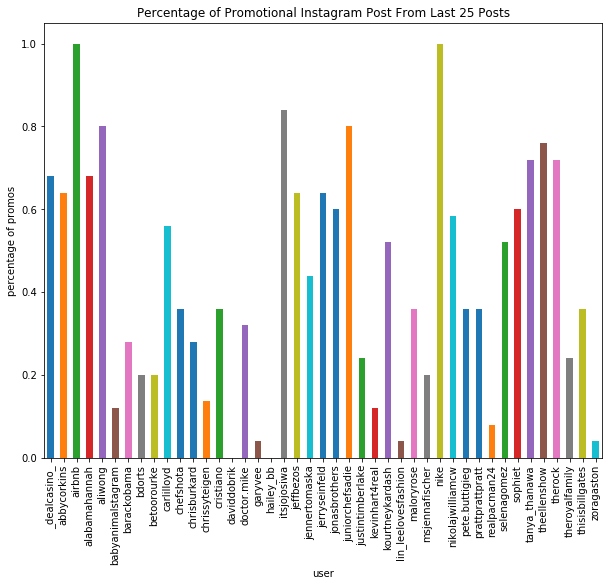

In [6]:
plt.figure(figsize=(10,8))
plt.xlabel('user')
plt.ylabel('percentage of promos')
plt.title('Percentage of Promotional Instagram Post From Last 25 Posts')
average_promos_by_user.plot.bar();


The selected users have varying percentage of promotional captions. There are some users (like Nike and Airbnb) that post only promotional material. There are people that never (at least in their most recent posts) have promotional material.

### Prepare Comments for Modeling


Convert target into two classes promotional and non-promotional.

In [7]:
target = posts_df.promo
y = pd.get_dummies(target).values


Use nltk's word_tokenizer function to transform captions nto a list of words.

In [8]:
data = posts_df['comment'].map(word_tokenize).values

In [9]:
total_vocabulary = set(word for comment in data for word in comment)
print("There are {} unique tokens in our dataset.".format(len(total_vocabulary)))

There are 8994 unique tokens in our dataset.


In [10]:
tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(list(posts_df.comment))
list_tokenized_headlines = tokenizer.texts_to_sequences(posts_df.comment)
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)

## Modeling

In [11]:
ops.reset_default_graph()

Create a neural network that uses an embedding layer at the beginning. We then use a bidirectional, long short term memory layer in hopes of reading the comments in both directions.

In [12]:
embedding_size = 128
input_ = Input(shape=(100,))
x = Embedding(10000, embedding_size)(input_)
x = Bidirectional(LSTM(25, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
# There are 2 different possible classes, so we use 2 neurons in our output layer
x = Dense(2, activation='softmax')(x)

model = Model(inputs=input_, outputs=x)

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 128)          1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 50)           30800     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102   

In [15]:
model.fit(X_t, y, epochs=2, batch_size=32, validation_split=0.1)

W0621 09:56:57.143733 140735550342016 deprecation.py:323] From /Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 958 samples, validate on 107 samples
Epoch 1/2
958/958 [==============================] - 4s 5ms/sample - loss: 0.6863 - accuracy: 0.5616 - val_loss: 0.6664 - val_accuracy: 0.6075
Epoch 2/2
958/958 [==============================] - 3s 3ms/sample - loss: 0.6551 - accuracy: 0.6242 - val_loss: 0.6427 - val_accuracy: 0.6168


In [16]:
model.fit(X_t, y, epochs=10, batch_size=32, validation_split=0.1)

Train on 958 samples, validate on 107 samples
Epoch 1/10
958/958 [==============================] - 3s 3ms/sample - loss: 0.4813 - accuracy: 0.8267 - val_loss: 1.0862 - val_accuracy: 0.4486
Epoch 2/10
958/958 [==============================] - 3s 3ms/sample - loss: 0.3009 - accuracy: 0.8904 - val_loss: 0.7257 - val_accuracy: 0.6729
Epoch 3/10
958/958 [==============================] - 3s 3ms/sample - loss: 0.1328 - accuracy: 0.9676 - val_loss: 0.8563 - val_accuracy: 0.7103
Epoch 4/10
958/958 [==============================] - 3s 3ms/sample - loss: 0.0551 - accuracy: 0.9906 - val_loss: 1.0347 - val_accuracy: 0.7290
Epoch 5/10
958/958 [==============================] - 3s 3ms/sample - loss: 0.0239 - accuracy: 0.9969 - val_loss: 0.9901 - val_accuracy: 0.7664
Epoch 6/10
958/958 [==============================] - 2s 3ms/sample - loss: 0.0088 - accuracy: 0.9990 - val_loss: 1.1284 - val_accuracy: 0.7477
Epoch 7/10
958/958 [==============================] - 3s 3ms/sample - loss: 0.0050 - accur

### Load testing dataframe

Tokenize comments using the same tokenizer that we fit on the training data. Also dummy the y-variable in the same manner as the training data.

In [17]:
test_df = pickle.load(open('../data/testing_posts.pkl', 'rb'))
test_df.head()

,age,comment,likes/views,link,promo,user
0,7 HOURS AGO,Summer is a great time to freshen up the kids’...,"99,928 likes",/By2uv66lhLI/,1,joannagaines
1,1 DAY AGO,They all look up to you so much @chipgaines Yo...,"421,056 likes",/Byy6YMplLMb/,0,joannagaines
2,2 DAYS AGO,Happy Father's Day to the plant daddy of all p...,"253,574 likes",/ByyNXAuFuQs/,0,joannagaines
3,6 DAYS AGO,Y’all really stepped up to the #ChipInChalleng...,"257,060 likes",/ByoEp79lJYX/,0,joannagaines
4,7 DAYS AGO,One more push y’all! We have til midnight CT t...,"176,897 likes",/ByleDigFgFA/,1,joannagaines


In [18]:
list_tokenized_headlines = tokenizer.texts_to_sequences(test_df['comment'].map(word_tokenize).values)
testing_X = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)

In [19]:
testing_y = pd.get_dummies(test_df['promo']).values

## Evaluation

Evaluate the model using the testing data.

In [20]:
model.evaluate(testing_X, testing_y, verbose=True)

248/248 [==============================] - 0s 2ms/sample - loss: 1.9763 - accuracy: 0.6774


[1.9762678953909105, 0.67741936]

Our model has an accuracy of about 70%.
Our initial model is saved for reproducibility and for the flask app.

In [21]:
# model.save('../instagram_flask/final_model.hdf5')

In [22]:
# delete the unsaved-model
del model

model = load_model("../instagram_flask/final_model.hdf5")

### Exploration of Predictions

We want to see what our model was getting correct and incorrect. First we start by getting the predicted probabilities for each testing post and added these predictions to the dataframe.

In [23]:
predictions = model.predict(testing_X).round(2)

In [24]:
predictions_df = pd.DataFrame(predictions, columns=['pred_not_promo', 'pred_promo'])
simple_test = test_df[['comment', 'promo']]
combined_posts_df = pd.concat((simple_test, predictions_df), axis=1)
combined_posts_df.head()

,comment,promo,pred_not_promo,pred_promo
0,Summer is a great time to freshen up the kids’...,1,0.0,1.0
1,They all look up to you so much @chipgaines Yo...,0,1.0,0.0
2,Happy Father's Day to the plant daddy of all p...,0,1.0,0.0
3,Y’all really stepped up to the #ChipInChalleng...,0,0.0,1.0
4,One more push y’all! We have til midnight CT t...,1,0.0,1.0


Create a new column that represents the highest predicted class. If the predicted promo is over 50% that it is class 1, and if it is less than or equal to 50% it predicted not promotional (0)

In [25]:
model_predicts = []
for row in range(len(combined_posts_df)):
    pred_promo = combined_posts_df['pred_promo'][row]
    pred_not_promo = combined_posts_df['pred_not_promo'][row]
    if pred_promo > pred_not_promo:
        model_predicts.append(1)
    else:
        model_predicts.append(0)

combined_posts_df['model_predicts'] = model_predicts
combined_posts_df.head()

,comment,promo,pred_not_promo,pred_promo,model_predicts
0,Summer is a great time to freshen up the kids’...,1,0.0,1.0,1
1,They all look up to you so much @chipgaines Yo...,0,1.0,0.0,0
2,Happy Father's Day to the plant daddy of all p...,0,1.0,0.0,0
3,Y’all really stepped up to the #ChipInChalleng...,0,0.0,1.0,1
4,One more push y’all! We have til midnight CT t...,1,0.0,1.0,1


Add another column to the dataframe that gives a boolean value for correctness.

In [26]:
correct_pred = []
for row in range(len(combined_posts_df)):
    true_class = combined_posts_df['promo'][row]
    model_pred = combined_posts_df['model_predicts'][row]
    if true_class == model_pred:
        correct_pred.append(True)
    else:
        correct_pred.append(False)

combined_posts_df['correct'] = correct_pred
combined_posts_df.head()

,comment,promo,pred_not_promo,pred_promo,model_predicts,correct
0,Summer is a great time to freshen up the kids’...,1,0.0,1.0,1,True
1,They all look up to you so much @chipgaines Yo...,0,1.0,0.0,0,True
2,Happy Father's Day to the plant daddy of all p...,0,1.0,0.0,0,True
3,Y’all really stepped up to the #ChipInChalleng...,0,0.0,1.0,1,False
4,One more push y’all! We have til midnight CT t...,1,0.0,1.0,1,True


View the predictions that it got wrong.

In [27]:
false_predictions = combined_posts_df.loc[combined_posts_df['correct'] == False]

In [28]:
false_pred_comments = [(comment, promo) for comment, promo in zip(false_predictions['comment'], false_predictions['promo'])]
false_pred_comments

[('Y’all really stepped up to the #ChipInChallenge and together we raised over $2 million for the fight against cancer! We go to @StJude next week and can’t wait to see the precious kids and present them with a check for $1.49 million from all of you. On top of that, $512,000 is going to our dear friend Gabe’s foundation, @bravelikegabe. She will forever inspire us to be brave. ❤️ Thank you ALL for chipping in with us! #NotTodayCancer',
  0),
 ('When @chipgaines and I got the chance to meet some of the kids at @stjude a couple of years ago, we walked away completely changed. These kids were so full of joy and hope—I’ll never forget it. That year, you all helped us raise $230,000 for those kids, and we want to do it again—but go even bigger! We’ve pulled a team together to help us with what we’re calling the #ChipInChallenge, and we hope you’ll be a part of helping us change lives. Head over to the link in profile to find out how you can help.',
  1),
 ('She is the most intentional, loy

75 of the 248 testing posts were incorrectly classified.

In [29]:
len(false_pred_comments)

75

Viewing the predictions that it got correct.

In [30]:
true_predictions = combined_posts_df.loc[combined_posts_df['correct'] == True]

In [31]:
true_pred_comments = [(comment, promo) for comment, promo in zip(true_predictions['comment'], true_predictions['promo'])]
true_pred_comments

[('Summer is a great time to freshen up the kids’ bedroom or play area, and I can’t wait for you to see what we’ve come up with this season. Check out our new bedding and wall decor collection (just for kids!), available at @Target. #HearthandHand',
  1),
 ("They all look up to you so much @chipgaines You're the strongest, bravest, funniest, and most loving man they know. You lead our babies well- Happy Father's Day! ❤️",
  0),
 ("Happy Father's Day to the plant daddy of all plant daddy's. I got my love for plants from this man- he has taught me that determination and hard work with a mix of patience and grace can not only help in the garden but also with family, business and life. I had the privilege of working with him for ten years at his tire shop and he taught me about these things 1st hand. I always thought I would take over his shop when he retired, this was at least the plan. Once I met Chip I started realizing I had some hidden dreams in my heart but was scared to let my dad d

Trends/Intersting:

* Did not always pick up on the word ad for promos
* Longer promos with the promotion at the end of the comment tended to be predicted as non-promotional
* Longer promos with the promotion at the beginning tending to be predicted as promotional

## Final Takeaways
The model was evaluated on 248 unseen captions by unseen instagram users. The model had an accuracy of 70%. Admittedly, this is not the best accuracy, however, when we were hand labeling the data there was a lot of gray area in some of the captions. We also had some sampling bias as we used a very small proportion of instagram users.

We explored the captions that were incorrectly classified and noticed some trends in the error. First, the most common type of error was to predict non-promotional when the post was promotional. One possible reason, is that there was slightly more non-promotional captions in our training data. A second related trend is that for long posts that were promotional, if the promotional material was at the end of the caption, it was harder to classify as promotional than if it was at the beginning of the caption. Third, there were some misclassified post that had the literal word "ad" in the caption. It is possible that this word did not show up much, if at all in the training data and therefore it did not learn that ad was promotional.